# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

import these libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [3]:
# your code here

BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

BSS_train = BSS_train.drop(['dteday','casual','registered', 'Unnamed: 0'], axis=1)
BSS_test = BSS_test.drop(['dteday','casual','registered', 'Unnamed: 0'], axis=1)

BSS_train.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,...,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.00000,13903.000000
mean,11.529454,0.029274,0.504567,0.680644,0.496732,0.475426,0.629051,0.190025,187.885492,0.253183,...,0.085305,0.140977,0.141121,0.144861,0.140833,0.142128,0.145508,0.260375,0.08286,0.000144
std,6.917884,0.168580,0.499997,0.466244,0.192699,0.171951,0.193100,0.122009,180.113476,0.434850,...,0.279346,0.348010,0.348158,0.351973,0.347862,0.349194,0.352625,0.438855,0.27568,0.011993
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,39.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,11.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,141.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,280.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


#### 1.2 Standardizing our data

In [5]:
# your code here

# Generating training set including standardizing
X_train_orig = BSS_train.loc[:,BSS_train.columns != 'counts']
X_test_orig = BSS_test.loc[:,BSS_train.columns != 'counts']


# scaling only the continuous predictors
categorical_columns = ['hour', 'holiday', 'year', 'workingday', 'spring', 'summer',
                       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
                       'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
                       'Cloudy', 'Snow', 'Storm']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed']

X_train_numerical = X_train_orig[numerical_columns]
X_test_numerical = X_test_orig[numerical_columns]

scaler = StandardScaler().fit(X_train_numerical)

# create and scale the training/test set
X_train = X_train_orig.copy()
X_test = X_test_orig.copy()

X_train[numerical_columns] = scaler.transform(X_train_numerical)
X_test[numerical_columns] = scaler.transform(X_test_numerical)

y_train = BSS_train['counts'].values.reshape(-1,1)
y_test = BSS_test['counts'].values.reshape(-1,1)

#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [6]:
# your code here
BikeOLSModel = LinearRegression()
BikeOLSModel.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

In [20]:
# your code here
train_r2_score = r2_score(y_train, BikeOLSModel.predict(X_train))
test_r2_score = r2_score(y_test, BikeOLSModel.predict(X_test))
print("Train Set R^2 Score: {:.4f}".format(train_r2_score))
print("Test Set R^2 Score: {:.4f}".format(test_r2_score))

BikeOLS_r2scores = {}
BikeOLS_r2scores['training'] = train_r2_score
BikeOLS_r2scores['test'] = test_r2_score

Train Set R^2 Score: 0.4065
Test Set R^2 Score: 0.4064


#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients.

In [21]:
# your code here

# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    # your code here
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    
    sample_indices = np.random.choice(size, size=size, replace=True)
    
    bootstrap_dataset_X = dataset_X.iloc[sample_indices, :]
    bootstrap_dataset_y = dataset_y[sample_indices]
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    # your code here
    
    # fit the model
    model.fit(dataset_X, dataset_y) 
    
    coefficients_dictionary = {k:v for k, v in zip(dataset_X.columns, model.coef_.ravel())}
    
    # return coefficients  in the variable  coefficients_dictioanry as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    
    # your code here

    
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in th list should be the output of calculate_coefficients
    
    if (len(regression_coefficients) <= 0):
        return []
    
    coeff_names = np.array(list(regression_coefficients[0].keys()), dtype='object')
    coeff_samples = [list(coeff_list.values()) for coeff_list in regression_coefficients]
    
    coeff_samples = np.array(coeff_samples)
    
    # Obtain bottom percentile values
    bottom_percentile = np.percentile(coeff_samples, q=significance_level/2, axis=0)
    
    # Obtain top percentile values
    top_percentile = np.percentile(coeff_samples, q=1-significance_level/2, axis=0)
    
    # Coefficients with bottom value greater than 0 or top value less than 0 are signficant
    significant_index = ((bottom_percentile > 0.0) | (top_percentile < 0.0))
 
    significant_coefficients = list(coeff_names[significant_index])
      
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [22]:
# Set the number of Bootstrap samplse to 500
N_bootstrap_samples = 500

In [25]:
regression_coefficients = []
for i in range(N_bootstrap_samples):
    sample = make_bootstrap_sample(X_train, y_train)
    coefficient_dict = calculate_coefficients(sample[0], sample[1], LinearRegression())
    regression_coefficients.append(coefficient_dict)
    
get_significant_predictors(regression_coefficients, 0.05)    

['hour',
 'holiday',
 'year',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'spring',
 'summer',
 'fall',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sept',
 'Oct',
 'Nov',
 'Dec',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Snow']

## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`?

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [26]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [51]:
# your code here

# RidgeCV
BikeRRModel = RidgeCV(cv=5, alphas=lambdas, fit_intercept=True)

BikeRRModel.fit(X_train, y_train) 

BikeRR_shrinkage_parameter = BikeRRModel.alpha_

Ridge_coefficients = BikeRRModel.coef_.ravel()

#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [52]:
# your code here

# Lasso
BikeLRModel = LassoCV(cv=5, alphas=lambdas, fit_intercept=True)

BikeLRModel.fit(X_train, y_train)

BikeLR_shrinkage_parameter = BikeLRModel.alpha_
Lasso_coefficients = BikeLRModel.coef_.ravel()

#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [53]:
# your code here

feature_names = X_train.columns

BikOLSparams = {k: v for k,v in zip(feature_names, BikeOLSModel.coef_.ravel())}
BikeRRparams = {k: v for k,v in zip(feature_names, BikeRRModel.coef_.ravel())}
BikeLRparams = {k: v for k,v in zip(feature_names, BikeLRModel.coef_.ravel())}   # coef_ of LassoCV is 1-D array

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0.  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

In [114]:
# your code here

print("Ridge predictors within 0.1 of 0:", list(feature_names[np.abs(Ridge_coefficients)<.1]))
print("----")
print("Lasso predictors within 0.1 of 0:", list(feature_names[np.abs(Lasso_coefficients)<.1]))

Ridge predictors within 0.1 of 0: []
----
Lasso predictors within 0.1 of 0: ['Mon']


<HR>
There is no resemblance between the list of insignficant coefficients and the redundant predictors found in HW3, Q5.
<HR>

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

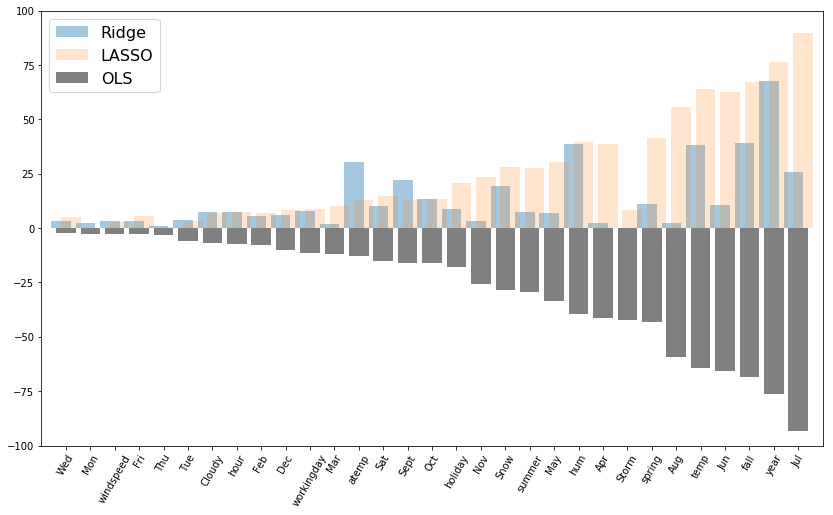

In [67]:
# your code here
si= np.argsort(np.abs(BikeOLSModel.coef_[0]))

n_coeffs = len(feature_names)

plt.figure(figsize=(14,8))
plt.bar(np.arange(n_coeffs)-0.2, np.abs(Ridge_coefficients)[si], alpha=0.4, label='Ridge')
plt.bar(np.arange(n_coeffs)+0.2, np.abs(Lasso_coefficients)[si], alpha=0.2, label='LASSO')
plt.bar(np.arange(n_coeffs), -np.abs(OLS_coefficients)[si], color='grey', label='OLS')
plt.xticks(range(n_coeffs), feature_names[si], rotation=60)
plt.xlim(-1,n_coeffs)
plt.ylim(-100,100)
plt.legend(fontsize=16)
plt.show()

#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients?

Recall from HW3 that `atemp` and `temp` are closely correlated.  Looking at the regression coefficients of these two predictors shows how Lasso and Ridge regression performs 'shrinkage' of the coefficient values.  First, examine the coefficient values from the ordinary linear regression:

In [113]:
print("OLS - temp: {:.4f}".format(BikOLSparams['temp']))
print("OLS - atemp: {:.4f}".format(BikOLSparams['atemp']))

OLS - temp: 64.2144
OLS - atemp: 12.8325


In contrast, examine the coefficient values of Lasso and Ridge regressions:

In [70]:
print("Lasso - temp: {:.4f}".format(BikeLRparams['temp']))
print("Lasso - atemp: {:.4f}".format(BikeLRparams['atemp']))

print("Ridge - temp: {:.4f}".format(BikeRRparams['temp']))
print("Ridge - atemp: {:.4f}".format(BikeRRparams['atemp']))

Lasso - temp: 63.8309
Lasso - atemp: 12.8684
Ridge - temp: 38.4562
Ridge - atemp: 30.3841


Observe that Lasso regression assigns similar coefficient values to the two predictors.  On the other hand, Ridge regression shrinks the value of `temp` such that two coefficient values are closer.

#### 2.7.1 How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1?

<HR>
Your answer here
<HR>

In the plot from Question 2.5, we see noticeable difference in the regression coefficients of plain linear regression and those from Lasso and Ridge regressions.  For instance, in contrast to plain linear regression, Ridge regression places noticeably smaller estimated coefficient values on month predictors (e.g. 'Jul', 'Jun', 'Aug', etc.).  On the other hand, Lasso closely follows the plain linear regression with the exception of 'storm' predictor.

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.

<HR>
Your answer here
<HR>
    
Interestingly, Ridge regression places the largest absolute coefficient on 'year' predictor and shrinks coefficient values on predictors related to months.  As aforementioned, Lasso closely follows the coefficient estimates of the plain linear regression with exception of 'storm' predictor.

Recall from Lab 4 that the penalty function of Ridge regression is
$$\lambda \sum_{j=1}^m \beta_{j}^{2}$$
while it is 
$$\lambda \sum_{j=1}^m |\beta_j|$$
for Lasso regression.

These differences in the penalty function has implications on how the coefficients of Lasso and Ridge regression are estimated, which can be visually explained with geometric interpretation.  

![Lasso (L1 Norm) vs Ridge (L2 Norm)](fig/L1_and_L2_balls.svg)

Lasso regression can be interpreted as optimization of coefficient values over a cross-polytope (i.e. a diamond in 2-dimenions) and Ridge regression as optimization over a n-sphere (i.e. a circle in 2-dimension).  The differenes in constraint boundaries explain why Lasso and Ridge regression assign different coefficient values to predictors that exhibit high collinearity.

#### 2.7.3 Is the significance related to the shrinkage in some way?

<HR>
Your answer here
<HR>
    
As visible from the geometric interpretation of the penalty function, optimization over a cross-polytope induces sparcity in estimated coefficient values.  As a result, we find that the predictor 'Mon' is not significant in Lasso regression in Question 2.4.  On the other hand, Ridge regression does not induce sparsity in coefficient estimate; consequently, all of the coefficients were significant. 

<HR>

<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`.

In [71]:
# your code here

# Create dataframe of higher order polynomials on a feature column up to order k
def gen_df_higher_orders(df, column, k):
    
    poly_model = PolynomialFeatures(k, include_bias=False)
    
    feature_data = df[column]
    
    
    # transform to get all the polynomial features of this column
    higher_orders = poly_model.fit_transform(feature_data.values.reshape(-1,1))
    
    feature_names = poly_model.get_feature_names([column])

    return pd.DataFrame(higher_orders[:,1:], columns=feature_names[1:])

def gen_df_interactions(df, categorical, numerical):
    
    poly_model= PolynomialFeatures(2, include_bias=False, interaction_only=True)
    
    all_interactions = pd.DataFrame(poly_model.fit_transform(df), columns = poly_model.get_feature_names(df.columns))
    
    
    # Generate the column names from interacations between categorical columns
    # including the categorical columns themselves and drop them
    poly_model.fit_transform(X_train[categorical])

    all_interactions = all_interactions.drop(poly_model.get_feature_names(categorical), axis=1)
    
    
    # Generate the column names from interactions between numerical columns
    # including the numerical columns themselves and drop them
    poly_model.fit_transform(X_train[numerical])

    all_interactions = all_interactions.drop(poly_model.get_feature_names(numerical), axis=1)
    
    return all_interactions

In [72]:
def get_poly_dataset(dataset_train, dataset_test, k):
    
    higher_orders_train =[gen_df_higher_orders(dataset_train, feature, k) for feature in numerical_columns]
    higher_orders_test = [gen_df_higher_orders(dataset_test, feature, k) for feature in numerical_columns]

    higher_orders_train = pd.concat(higher_orders_train, axis=1)
    higher_orders_test = pd.concat(higher_orders_test, axis=1)

    higher_orders_columns = higher_orders_train.columns

    # scale higher order polynomial features
    scaler = StandardScaler().fit(higher_orders_train)

    higher_orders_train[higher_orders_columns] = scaler.transform(higher_orders_train)
    higher_orders_test[higher_orders_columns] = scaler.transform(higher_orders_test)

    # concatenate to get the full data frames
    poly_train = pd.concat([dataset_train.reset_index().drop(['index'], axis=1)] + [higher_orders_train], axis=1)
    poly_test = pd.concat([dataset_test.reset_index().drop(['index'], axis=1)] + [higher_orders_test], axis=1)
    
    return (poly_train, poly_test)

In [73]:
X_poly_train, X_poly_test = get_poly_dataset(X_train, X_test, 4)

#### 3.2.1 What are the dimensions of this 'design matrix'?

In [74]:
X_poly_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2', 'temp^3',
       'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'hum^2', 'hum^3', 'hum^4',
       'windspeed^2', 'windspeed^3', 'windspeed^4'],
      dtype='object')

In [75]:
X_poly_train.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,...,temp^4,atemp^2,atemp^3,atemp^4,hum^2,hum^3,hum^4,windspeed^2,windspeed^3,windspeed^4
count,13903.000000,13903.000000,13903.000000,13903.000000,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,13903.000000,13903.000000,...,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04
mean,11.529454,0.029274,0.504567,0.680644,4.533971e-15,-5.184182e-16,-6.715081e-16,2.018637e-15,0.253183,0.258865,...,2.799285e-15,5.740771e-16,8.715846e-16,4.254602e-15,1.907638e-15,-1.058247e-16,-3.434672e-15,9.098910e-16,6.119982e-16,-3.260716e-16
std,6.917884,0.168580,0.499997,0.466244,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.434850,0.438027,...,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,0.000000,0.000000,0.000000,0.000000,-2.474055e+00,-2.764988e+00,-3.257769e+00,-1.557515e+00,0.000000,0.000000,...,-5.147625e-01,-9.304302e-01,-8.220754e+00,-4.712201e-01,-9.190551e-01,-1.281820e+01,-3.909072e-01,-6.197134e-01,-8.102365e-01,-1.785218e-01
25%,6.000000,0.000000,0.000000,0.000000,-8.133773e-01,-8.265766e-01,-7.719159e-01,-7.009933e-01,0.000000,0.000000,...,-5.060281e-01,-7.928673e-01,-1.881868e-01,-4.663738e-01,-7.650356e-01,-1.273693e-01,-3.858789e-01,-5.725461e-01,-1.709233e-01,-1.782270e-01
50%,11.000000,0.000000,1.000000,1.000000,1.696154e-02,5.451955e-02,4.913269e-03,3.258315e-02,0.000000,0.000000,...,-4.051289e-01,-2.619651e-01,3.236408e-02,-3.581280e-01,-3.574097e-01,4.373286e-02,-3.240565e-01,-3.155264e-01,-1.067849e-01,-1.665422e-01
75%,18.000000,0.000000,1.000000,1.000000,8.473004e-01,8.477969e-01,7.817424e-01,5.219073e-01,1.000000,1.000000,...,5.585169e-02,4.103700e-01,2.702095e-01,-1.693190e-02,5.120220e-01,2.214529e-01,4.308982e-02,1.776485e-01,-8.032379e-02,-9.642754e-02
max,23.000000,1.000000,1.000000,1.000000,2.611770e+00,3.050828e+00,1.921092e+00,5.415149e+00,1.000000,1.000000,...,1.114033e+01,7.738178e+00,1.111864e+01,1.849309e+01,8.835145e+00,2.681217e+00,1.977104e+01,1.757132e+01,2.945729e+01,4.248249e+01


<HR>
13903 x 43
<HR>

#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors?

<HR>
Overfitting may be a problem when applying a trained regression models using polynomial features.
<HR>

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model.

In [76]:
# your code here

BikeOLSPolyModel = LinearRegression()

BikeOLSPolyModel.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### 3.4.1 What are the training and test $R^2$ scores?

In [27]:
# your code here

BikeOLSPoly_r2scores = {}

BikeOLSPoly_r2scores['training'] = BikeOLSPolyModel.score(X_poly_train, y_train)
BikeOLSPoly_r2scores['test'] = BikeOLSPolyModel.score(X_poly_test, y_test)

print(BikeOLSPoly_r2scores)

{'training': 0.42230805166587104, 'test': 0.42027912762252395}


<HR>
Training: 0.422
    
Test: 0.420
<HR>

#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

As a reminder, the original linear model from question 1 is

In [78]:
print(BikeOLS_r2scores)

{'training': 0.4065387827969087, 'test': 0.40638554757102285}


We see that the polynomial regression models performs slightly better in terms of $R^2$.

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample.

In [87]:
# your code here
    
MLR_scores = cross_val_score(LinearRegression(), X_poly_train, y_train, cv=5)
    
print("Mean: ", np.mean(MLR_scores))
print("Std. Dev: ", np.std(MLR_scores))

Mean:  0.26727805322296977
Std. Dev:  0.09109366555046658


We've got error bars for our training set $R^2$.  These scores aren't comparable to those we got in 3.4 because they're training set and not validation set scores, but we at least have a sense for the uncertainty. 

#### 3.6 Plot the $R^2$ scores generated from k-fold cross validation (for each k) as a box and whisker plot.

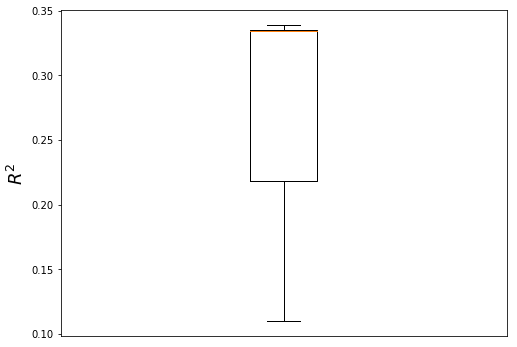

In [96]:
plt.figure(figsize=(8,6))
plt.boxplot(MLR_scores)
plt.ylabel(r"$R^2$", fontsize=18)
plt.xticks([])
plt.show()

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives.

In [97]:
k_fold = KFold(n_splits=5)

kfold_ks = list(range(5))

x_kfold_scores = []
poly2_kfold_scores = []
poly4_kfold_scores = []

for k, (train_index, test_index) in enumerate(k_fold.split(X_train, y_train)):
    # Create k-th Train & Test DataFrames
    X_kfold_train = pd.DataFrame(X_train.values[train_index], columns=X_train.columns)  
    X_kfold_test =  pd.DataFrame(X_train.values[test_index], columns=X_train.columns)
    
    y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
    
    # Create 2-nd and 4-th degree polynomial feature design matrices
    poly2_kfold_train, poly2_kfold_test = get_poly_dataset(X_kfold_train, X_kfold_test, 2)
    poly4_kfold_train, poly4_kfold_test = get_poly_dataset(X_kfold_train, X_kfold_test, 4)
    
    # Train
    kfold = LinearRegression().fit(X_kfold_train, y_kfold_train)
    poly2 = LinearRegression().fit(poly2_kfold_train, y_kfold_train)
    poly4 = LinearRegression().fit(poly4_kfold_train, y_kfold_train)
    
    # Score
    x_kfold_scores.append(kfold.score(X_kfold_test, y_kfold_test))
    poly2_kfold_scores.append(poly2.score(poly2_kfold_test, y_kfold_test))
    poly4_kfold_scores.append(poly4.score(poly4_kfold_test, y_kfold_test))

In [98]:
all_kfold_scores = np.array([x_kfold_scores, poly2_kfold_scores, poly4_kfold_scores])

In [99]:
print("Model 1: Base Features")
print("Mean: ", all_kfold_scores.mean(axis=1)[0])
print("Std. Dev:", all_kfold_scores.std(axis=1)[0])

Model 1: Base Features
Mean:  0.2579944364362188
Std. Dev: 0.0922005509622767


In [100]:
print("Model 2:  Base Features plus polynomial features to order 2")
print("Mean: ", np.mean(poly2_kfold_scores))
print("Std. Dev:", np.std(poly2_kfold_scores))

Model 2:  Base Features plus polynomial features to order 2
Mean:  0.26325875116942654
Std. Dev: 0.0767035248374377


In [101]:
print("Model 3:  Base Features plus polynomial features to order 4")
print("Mean: ", np.mean(poly4_kfold_scores))
print("Std. Dev:", np.std(poly4_kfold_scores))

Model 3:  Base Features plus polynomial features to order 4
Mean:  0.2672780532229682
Std. Dev: 0.0910936655504684


Based purely on model selection via k-fold cross validation, the base model with polynomial features of degree 4 is the best.

#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

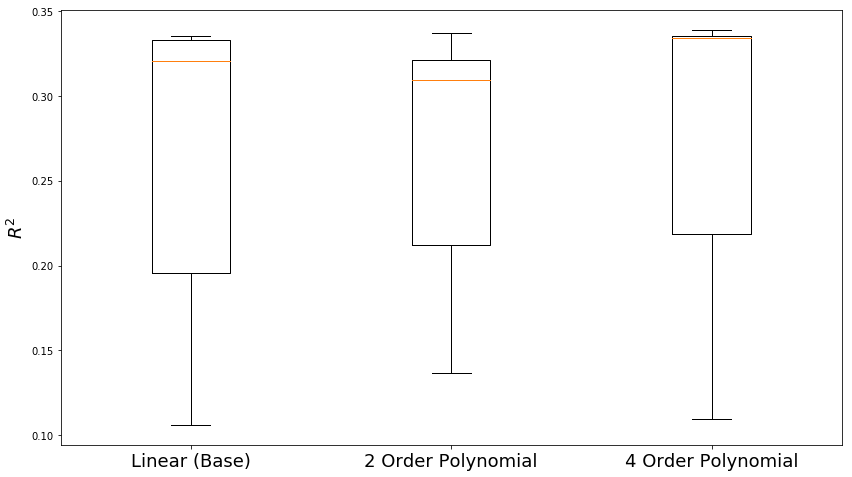

In [104]:
plt.figure(figsize=(14,8))
plt.boxplot([x_kfold_scores, poly2_kfold_scores, poly4_kfold_scores])
plt.ylabel(r"$R^2$", fontsize=18)
plt.xticks(range(1,4), ['Linear (Base)', '2 Order Polynomial', '4 Order Polynomial'], fontsize=18)
plt.show()

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [105]:
poly2_train, poly2_test = get_poly_dataset(X_train, X_test, 2)
poly4_train, poly4_test = get_poly_dataset(X_train, X_test, 4)

In [106]:
base_model = LinearRegression().fit(X_train, y_train)
poly2_model = LinearRegression().fit(poly2_train, y_train)
poly4_model = LinearRegression().fit(poly4_train, y_train)

In [107]:
print("R-squared for Base Model on Test: ", base_model.score(X_test, y_test))
print("R-squared for 2 Degree Polynomial Features Model on Test: ", poly2_model.score(poly2_test, y_test))
print("R-squared for 4 Degree Polynomial Features Model on Test: ", poly4_model.score(poly4_test, y_test))

R-squared for Base Model on Test:  0.40638554757102285
R-squared for 2 Degree Polynomial Features Model on Test:  0.41076037422804523
R-squared for 4 Degree Polynomial Features Model on Test:  0.42027912762252395


The models performed better on the test set than on the CV validation sets.  However, the relative model performance was somewhat similar.